# Train Gaussian Mixture Regression

In [1]:
using AutomotiveDrivingModels
using RandomForestBehaviors

## Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange

dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

nframes = nrow(dset.dataframe)
ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [11]:
train_def = BehaviorTrainDefinition(
                                            GMR_TrainParams(indicators=INDICATOR_SET_SMALL, n_gmm_iter=20, n_init=1, n_components=10),
                                            [
                                                BehaviorParameter(:n_components, [10,20,30], 2),
                                                BehaviorParameter(:tol, [0.1, 0.15, 0.2], 2),
                                                BehaviorParameter(:min_covar, [1e-7,1e-6,1e-5,1e-4], 2),
                                                BehaviorParameter(:max_n_indicators, [3,4,5], 2),
                                                BehaviorParameter(:unlearned_component_weight, [0.01,0.05,0.1], 2)
                                                # BehaviorParameter(:use_PCA, [false, true], 1),
                                            ])
preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
GMR Train Params
	targets: (:f_des_angle,:f_accel)
	indicators: [:posFyaw,:speed,:velFs,:velFt,:turnrate,:acc,:accFs,:accFt,:d_ml,:d_mr,:est_ttcr,:a_req_stayinlane,:has_lane_right,:has_lane_left,:d_front,:dv_x_front,:acc_req_front,:inv_ttc_front,:inv_timegap_front,:past_1_acc,:past_2_acc,:past_3_acc,:past_4_acc,:past_1_f_des_angle,:past_2_f_des_angle,:past_3_f_des_angle,:past_4_f_des_angle]
	n_components:     10
	max_n_indicators: 3
	use_PCA:   false
	min_covar:        1.0e-6

hyperparams:
	n_components:        [10, >20<, 30]
	tol:                 [0.1, >0.15<, 0.2]
	min_covar:           [1.0e-7, >1.0e-6<, 1.0e-5, 0.0001]
	max_n_indicators:    [3, >4<, 5]
	unlearned_component_weight: [0.01, >0.05<, 0.1]


In [12]:
# AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
#                     train_def, dset, preallocated_data, cv_split_inner)
# print(train_def); sleep(0.1)

## Train

In [13]:
MR = train(dset, preallocated_data, train_def.trainparams, FoldSet(cv_split_outer, fold, false, :frame));
print(MR.gmr)

GMR:
1
	[   -0.003829    0.012032    0.003628] + [    0.001891]
	[    0.860083    0.009783   -1.166867] + [   -0.010610]
2
	[    0.055511    0.014988   -0.056706] + [   -0.001471]
	[   -0.392296    0.003713    0.111707] + [   -0.017730]
3
	[    0.001916    0.013332   -0.001969] + [    0.001021]
	[   -0.254255   -0.002941   -0.030700] + [   -0.012172]
4
	[    0.029070    0.009093   -0.030186] + [    0.000303]
	[   -0.026485   -0.001942   -0.268457] + [   -0.029006]
5
	[    0.009281    0.012366   -0.009388] + [    0.000790]
	[   -0.137689   -0.000322   -0.149524] + [   -0.007411]
6
	[   -0.041589    0.014564    0.042941] + [    0.003950]
	[   -0.290932    0.000531    0.007146] + [   -0.012601]
7
	[   -0.090904    0.014649    0.092799] + [    0.002728]
	[   -0.281600   -0.003643   -0.003924] + [   -0.009837]
8
	[   -0.018853    0.000435    0.023089] + [   -0.022908]
	[   -0.263226    0.000522    0.000071] + [   -0.009740]
9
	[   -0.008268    0.009894   -0.007500] + [    0.393532]
	[   -0.

## Likelihood

In [14]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nframes
    if trains_with_nona(MR)
        logl = calc_action_loglikelihood(MR, dset.dataframe_nona, frameind)
    else
        logl = calc_action_loglikelihood(MR, dset.dataframe, frameind)
    end
    
    if is_in_fold(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

println("extrema train: ", extrema(arr_logl_train))
println("extrema test:  ", extrema(arr_logl_test))

extrema train: (-0.5969509125176167,8.250306202564875)
extrema test:  (-0.5969509125176167,8.225915656103531)


In [15]:
get_indicators(MR)

3-element Array{AutomotiveDrivingModels.Features.AbstractFeature,1}:
 AutomotiveDrivingModels.Features.Feature_Acc()                 
 AutomotiveDrivingModels.Features.Feature_Past{:f_des_angle,1}()
 AutomotiveDrivingModels.Features.Feature_AccFs()               

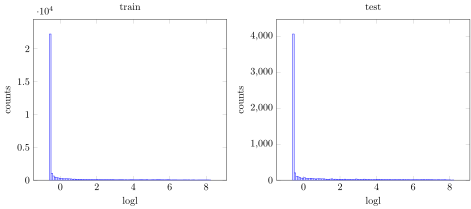

In [16]:
using PGFPlots
g = GroupPlot(2,1, groupStyle="horizontal sep=50pt")
push!(g, Axis(Plots.Histogram(arr_logl_train, bins=100), ymin=0, title="train", xlabel="logl", ylabel="counts"))
push!(g, Axis(Plots.Histogram(arr_logl_test, bins=100), ymin=0, title="test", xlabel="logl", ylabel="counts"))
g

In [9]:
using Discretizers
disc = LinearDiscretizer(collect(linspace(extrema(arr_logl_train)..., 51)))
counts = zeros(Int, nlabels(disc))
for v in arr_logl_train
    counts[encode(disc, v)] += 1
end
println("counts train: ", counts)

counts train: 

In [10]:
disc = LinearDiscretizer(collect(linspace(extrema(arr_logl_test)..., 51)))
counts = zeros(Int, nlabels(disc))
for v in arr_logl_test
    counts[encode(disc, v)] += 1
end
println("counts train: ", counts)

LoadError: LoadError: Bin edges must be sorted in increasing order
while loading In[10], in expression starting on line 1

[32443,1,0,0,1,0,0,0,1,0,0,2,0,0,0,0,1,0,1,1,0,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,0,2,2,2,13]
